In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np 

import torch
import torch.nn.functional as F

print(torch.__version__)

GEN = torch.Generator().manual_seed(1337)

1.12.1


### Intuition behind BatchNorm

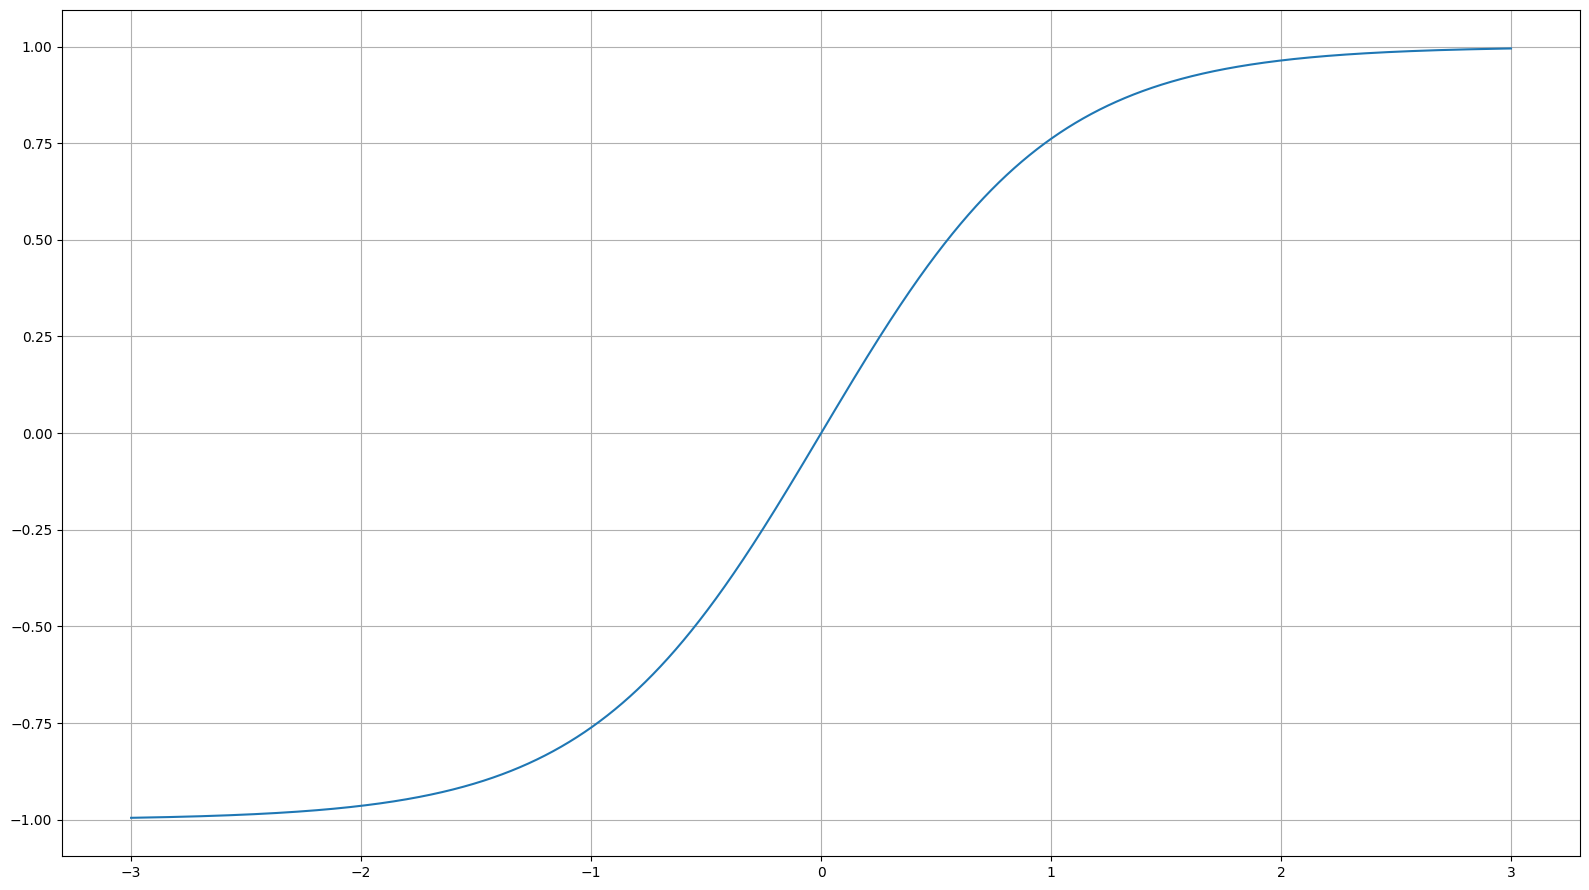

In [2]:
X_ar = torch.arange(-3, 3, 1/1_000)
X_out = torch.tanh(X_ar)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X_ar, X_out)
# ax_1 = ax.twinx()
# ax_1.hist(torch.randn(10_000, generator=GEN), bins=30, alpha=0.3)
fig.tight_layout()
plt.grid()
plt.show()


### Batch norm implementation in concise PyTorch

In [3]:
class BatchNorm:
    def __init__(self, dim, eps=1e-5, momentum=0.1, train=True):
        self.eps = eps
        self.momentum = momentum
        self.train = train

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Initialise zero mean & unit variance
        self.bn_mean = torch.zeros(dim)
        self.bn_var = torch.ones(dim)
        
    def parameters():
        return [self.gamma, self.beta]
    
    def __call__(self, X):
        if self.train:
            X_mean = X.mean(0, keepdim=True)
            X_var = X.var(0, keepdim=True)
            
        else:
            X_mean = self.bn_mean
            X_var = self.bn_std
            
        X_out = (X - X_mean) / torch.sqrt(X_var + self.eps)
        
        if self.train:
            with torch.no_grad():
                self.bn_mean = (1 - self.momentum) * self.bn_mean + self.momentum * X_mean
                self.bn_var = (1 - self.momentum) * self.bn_var + self.momentum * X_var
        
        return X_out


### Load data

In [4]:
# Read and process shakespeare

import string

import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from nltk.corpus import stopwords
from nltk import word_tokenize


DATA_DIR = "data/shakespear.txt"


def load_preprocess_data():
    with open(DATA_DIR, "r") as f:
        data = [l.rstrip().lower() for l in f.readlines()]
    
    data = [line.translate(str.maketrans('', '', string.punctuation)) for line in data]
    data = [word_tokenize(line) for line in data]

    return data

def remove_stopwords(data, sw=stopwords.words("english")):
    res = []
    for line in data:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res

data = load_preprocess_data()
data_clean = remove_stopwords(data)

display(data[:2])
print("=" * 30)
display(data_clean[:2])



[['that',
  'poor',
  'contempt',
  'or',
  'claimd',
  'thou',
  'slept',
  'so',
  'faithful'],
 ['i',
  'may',
  'contrive',
  'our',
  'father',
  'and',
  'in',
  'their',
  'defeated',
  'queen']]

[['poor', 'contempt', 'claimd', 'thou', 'slept', 'faithful'],
 ['may', 'contrive', 'father', 'defeated', 'queen']]

In [5]:
# Determine vocab size
from collections import Counter


data_clean_flat = [word for line in data_clean for word in line]
vocab = Counter(data_clean_flat)
print(f"Vocab size: {len(vocab)}")

vocab_index = {k: i for i, k in enumerate(vocab)}
# Add special token for unknown words
vocab_index["<UNK>"] = len(vocab_index)


Vocab size: 3407


### Make train, eval, test splits

In [6]:
# Train example is a pair of words context -> to_predict
def create_dataset(corpus, vocab_index, context_len):
    feats = []
    labels = []
    for i in range(context_len, len(corpus)):
        label = vocab_index.get(corpus[i], vocab_index["<UNK>"])
        labels.append(label)
        
        feats.append([vocab_index.get(w, vocab_index["<UNK>"]) for w in corpus[i - context_len: i]])
    
    feats = torch.tensor(feats)
    labels = torch.tensor(labels)
    
    print(feats.shape)
    print(labels.shape)
    
    return feats, labels


CONTEXT_LEN = 3
X, y = create_dataset(data_clean_flat, vocab_index, CONTEXT_LEN)
print(X)
print(y)

tr = int(len(y) * 0.8)
val = int(len(y) * 0.9)

X_train = X[:tr]
X_val = X[tr: val]
X_test = X[:val]

y_train = y[:tr]
y_val = y[tr: val]
y_test = y[val:]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


torch.Size([9560, 3])
torch.Size([9560])
tensor([[   0,    1,    2],
        [   1,    2,    3],
        [   2,    3,    4],
        ...,
        [3406,   66,  209],
        [  66,  209,  346],
        [ 209,  346,  443]])
tensor([  3,   4,   5,  ..., 346, 443, 445])
torch.Size([7648])
torch.Size([956])
torch.Size([956])


### MLP w/ & w/o BatchNorm

In [7]:
class Tanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def __call__(self, X):
        self.out = self.forward(X)
        return self.out
    
    def forward(self, X):
        return torch.tanh(X)
    
    def parameters(self):
        return []



# Simple MLP model
class MLPBn(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, vocab_size: int, bias: bool = False, add_bn: bool = True):
        super().__init__()
        
        self.input_linear = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.add_bn = add_bn
        
        if add_bn:
            self.bn_in = torch.nn.BatchNorm1d(hidden_dim)
            self.mlp = torch.nn.ModuleList([
                torch.nn.Linear(hidden_dim, hidden_dim, bias=False),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Tanh()
            ] for _ in range(3))
            self.bn_out = torch.nn.BatchNorm1d(vocab_size)
            
        else:
            self.mlp = torch.nn.ModuleList([
                orch.nn.Linear(hidden_dim, hidden_dim, bias=False),
                torch.nn.Tanh()
            ] for _ in range(3))
            
        self.output = torch.nn.Linear(hidden_dim, vocab_size, bias=False)
        
    def init_weights(self, layer):
        # Init weights with normal distribution
        if isinstance(layer, torch.nn.Linear):
            torch.nn.init.normal_(layer.weight)

    def forward(self, X):
        if self.add_bn:
            X = torch.tanh(self.bn_in(self.input_linear(X)))
        else:
            X = torch.tanh(self.input_linear(X))
                       
        for layer in self.mlp:
            X = layer(X)
            
        if self.add_bn:
            return self.bn_out(self.output(X))
        
        return self.output(X)
    

In [8]:
VOCAB_SIZE = len(vocab) + 100
EMBEDDING_DIM = 10
# Input w.r. to some context, for our example context window = 1
INPUT_DIM = CONTEXT_LEN * EMBEDDING_DIM
HIDDEN_DIM = 100

embeddings = torch.randn((VOCAB_SIZE, EMBEDDING_DIM), generator=GEN)
print(embeddings.shape)


torch.Size([3507, 10])


In [9]:
# Can also be done with torch.nn.Sequential:
mlp_bn_model = torch.nn.Sequential(OrderedDict([
    ("linear_1", torch.nn.Linear(INPUT_DIM, HIDDEN_DIM, bias=False)), ("batch_norm_1", torch.nn.BatchNorm1d(HIDDEN_DIM)), ("tanh_1", Tanh()),
    ("linear_2", torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)), ("batch_norm_2", torch.nn.BatchNorm1d(HIDDEN_DIM)), ("tanh_2", Tanh()),
    ("linear_3", torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)), ("batch_norm_3", torch.nn.BatchNorm1d(HIDDEN_DIM)), ("tanh_3", Tanh()),
    ("linear_4", torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)), ("batch_norm_4", torch.nn.BatchNorm1d(HIDDEN_DIM)), ("tanh_4", Tanh()),
    ("linear_5", torch.nn.Linear(HIDDEN_DIM, VOCAB_SIZE, bias=False)), ("batch_norm_5", torch.nn.BatchNorm1d(VOCAB_SIZE))
]))


mlp_model = torch.nn.Sequential(OrderedDict([
    ("linear_1", torch.nn.Linear(INPUT_DIM, HIDDEN_DIM, bias=False)), ("tanh_1", Tanh()),
    ("linear_2", torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)), ("tanh_2", Tanh()),
    ("linear_3", torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)), ("tanh_3", Tanh()),
    ("linear_4", torch.nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)), ("tanh_4", Tanh()),
    ("linear_5", torch.nn.Linear(HIDDEN_DIM, VOCAB_SIZE, bias=False)),
]))


def init_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.normal_(layer.weight)
        
mlp_bn_model.apply(init_weights)
mlp_model.apply(init_weights)


def set_requires_grad(net):
    parameters = [embeddings] + [p for layer in net for p in layer.parameters()]
    print(f"Total parameters: {sum(p.nelement() for p in parameters)}") 
    for p in parameters:
        p.requires_grad = True
        
set_requires_grad(mlp_model)
set_requires_grad(mlp_bn_model)


Total parameters: 418770
Total parameters: 426584


### Training loop

In [10]:
epochs = 200_000
batch_size = 32
learning_rate = 3e-3


def train_model(model, num_epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, debug=False):
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    losses = []
    ud = []
    for epoch in range(num_epochs):
        # Create Batch ourselves, DataLoader will be introduced later
        idx = torch.randint(0, X_train.shape[0], (batch_size,), generator=GEN)
        X_b, y_b = X_train[idx], y_train[idx]

        # Forward
        optim.zero_grad()
        emb = embeddings[X_b]
        emb = emb.view(emb.shape[0], -1)
        y_pred = model(emb)

        # Backward
        l = loss(y_pred, y_b)
        l.retain_grad()
        l.backward(retain_graph=True)
        # Usually there is a gradient clipping, but we skip it in this notebook
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2., norm_type=2)
        optim.step()

        # track stats
        if epoch % 10000 == 0: # print every once in a while
            print(f"{epoch:7d} / {num_epochs:7d}: {l:.4f}")
            losses.append(l.log10())

        if epoch >= 1000 and debug:
            break


In [11]:
train_model(mlp_model, debug=True)
train_model(mlp_bn_model, debug=True)


      0 /  200000: 37.1242
      0 /  200000: 8.9590


### Visualise gradients

In [12]:
def plot_gradient_hist(model, instance_type=torch.nn.Linear):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []

    for i, layer in enumerate(model[:-1]):
        if isinstance(layer, instance_type):
            t = layer.weight.grad
            print(f"layer {i} {layer.__class__.__name__}: mean {t.mean()}, std {t.std()}")
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"layer {i} ({layer.__class__.__name__}")
            
    plt.legend(legends);
    plt.title("gradient distribution")
    plt.show()
    
    
def plot_layer_hist(model, instance_type=Tanh):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []

    for i, layer in enumerate(model[:-1]):
        if isinstance(layer, instance_type):
            t = layer.out
            print(f"layer {i} {layer.__class__.__name__}: mean {t.mean()}, std {t.std()}, outrageous: {(t.abs() > 0.97).float().mean()*100}")
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"layer {i} ({layer.__class__.__name__}")
            
    plt.legend(legends);
    plt.title("Activation distribution")
    plt.show()



layer 0 Linear: mean 0.020845754072070122, std 0.9143664836883545
layer 2 Linear: mean 0.0009890988003462553, std 0.3055434823036194
layer 4 Linear: mean 0.0010203967103734612, std 0.12900273501873016
layer 6 Linear: mean 0.0008518002578057349, std 0.05246027186512947


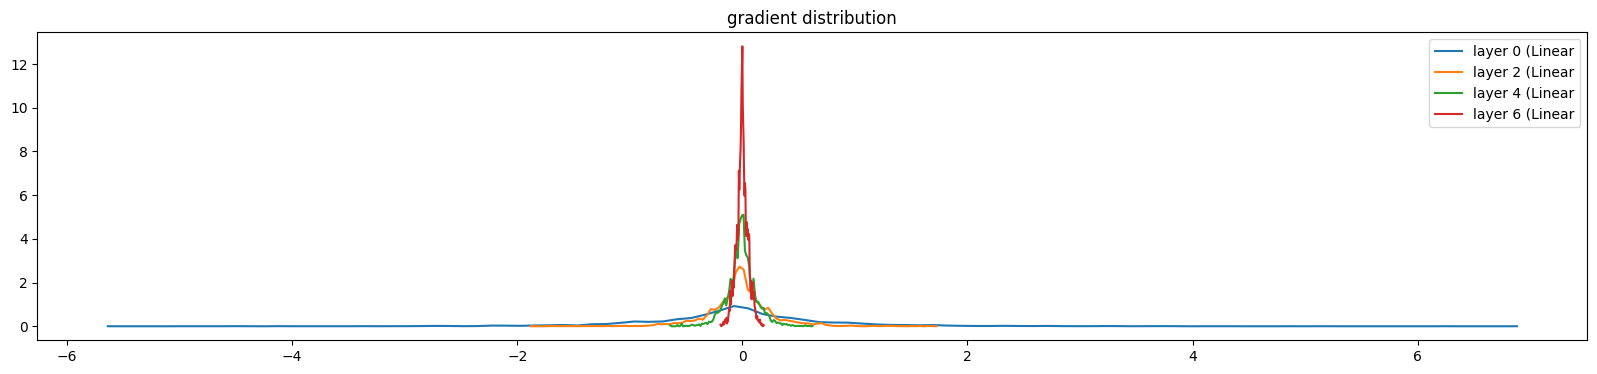

layer 1 Tanh: mean -0.002998421201482415, std 0.9271204471588135, outrageous: 70.5
layer 3 Tanh: mean 0.01953498087823391, std 0.9558716416358948, outrageous: 82.03125
layer 5 Tanh: mean 0.010202372446656227, std 0.9581791162490845, outrageous: 82.3125
layer 7 Tanh: mean -0.020281238481402397, std 0.9595978856086731, outrageous: 82.90625


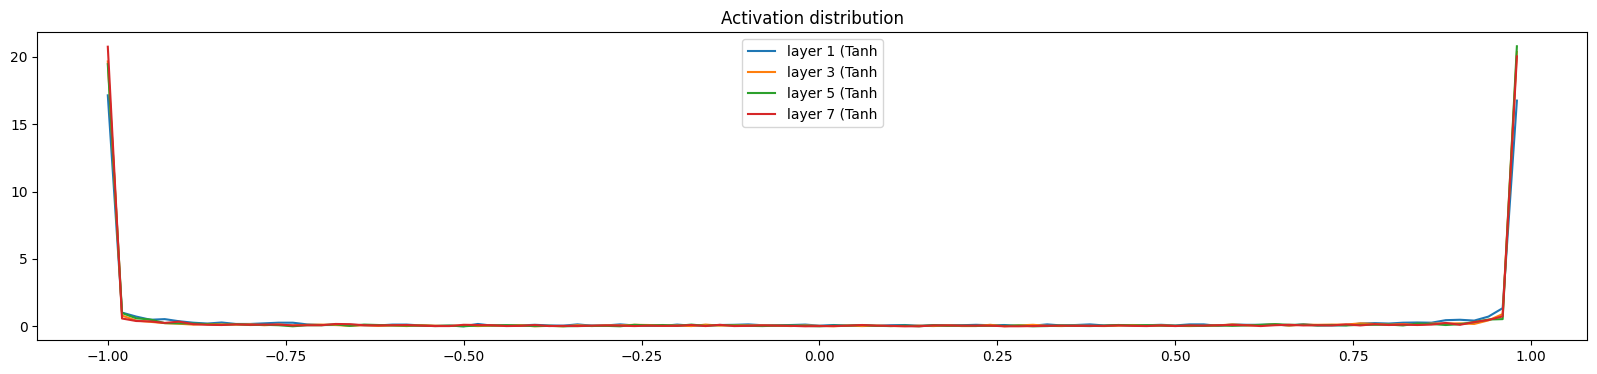

In [13]:
plot_gradient_hist(mlp_model)
plot_layer_hist(mlp_model)


layer 0 Linear: mean -4.038864790345542e-05, std 0.004970280919224024
layer 3 Linear: mean 6.489341103588231e-06, std 0.00245499680750072
layer 6 Linear: mean 8.801526746538002e-06, std 0.002380642807111144
layer 9 Linear: mean -3.0613889521191595e-06, std 0.002189846243709326
layer 12 Linear: mean 1.1529709631474816e-08, std 0.00032274157274514437


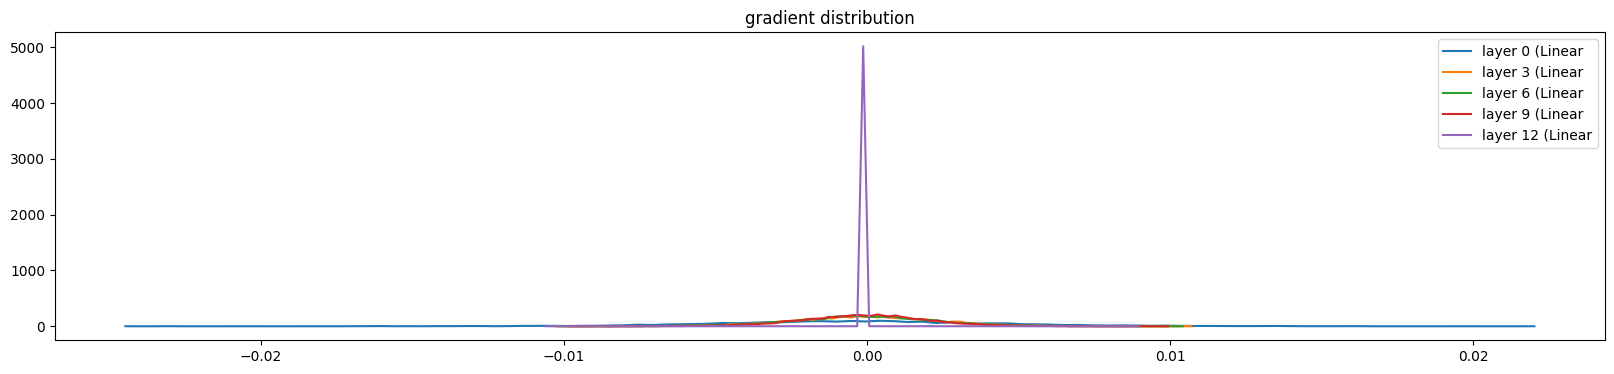

layer 2 Tanh: mean 0.004126956686377525, std 0.6363093852996826, outrageous: 3.343750238418579
layer 5 Tanh: mean -0.0002755880414042622, std 0.6366972923278809, outrageous: 3.09375
layer 8 Tanh: mean -0.00048068680916912854, std 0.6332812309265137, outrageous: 3.25
layer 11 Tanh: mean -0.004503387957811356, std 0.6351727843284607, outrageous: 3.0625


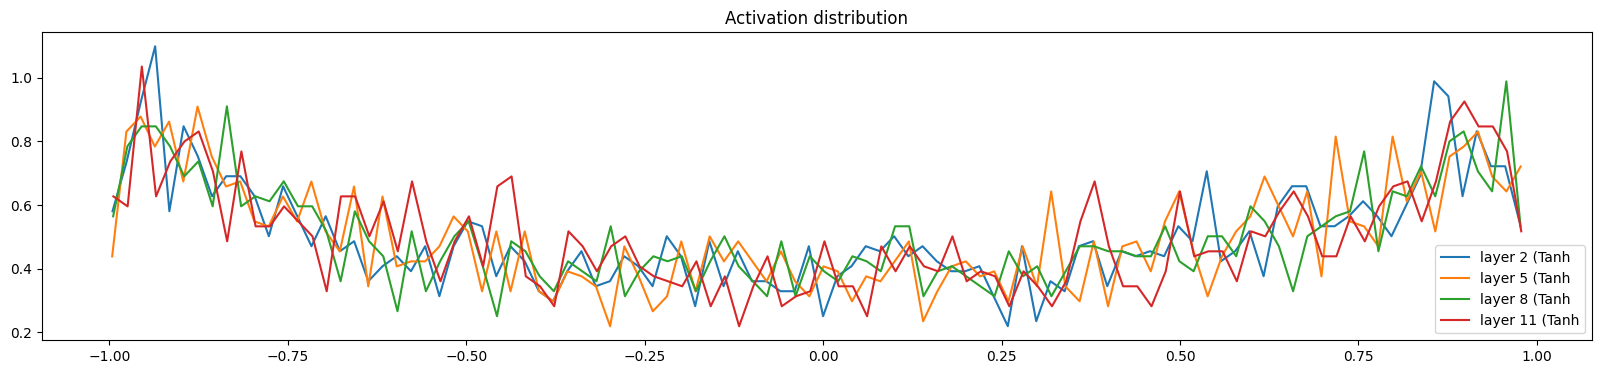

In [14]:
plot_gradient_hist(mlp_bn_model)
plot_layer_hist(mlp_bn_model)
